# Enhanced Header
"""
# **Credit Card Fraud Detection with Decision Trees and SVM**

## Project Overview
This notebook compares Decision Tree and Support Vector Machine (SVM) algorithms for credit card fraud detection.
We analyze how feature selection impacts model performance and explore the trade-offs between algorithms.

## Objectives:
1. Build and evaluate Decision Tree and SVM models for fraud detection
2. Compare model performance with full feature set vs. selected features
3. Analyze the impact of feature dimensionality on each algorithm
4. Provide insights on algorithm selection for fraud detection

## Dataset: Credit card transaction data with anonymized features and binary fraud labels
"""

# Enhanced Imports with Documentation

In [1]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import pandas as pd
import numpy as np  # Added for numerical operations
import matplotlib.pyplot as plt
import seaborn as sns  # Added for enhanced visualizations
%matplotlib inline

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve  # Enhanced metrics
from sklearn.svm import LinearSVC

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# Data Loading and Initial Exploration

In [2]:
# Download and load the credit card fraud dataset
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

print("📊 Loading credit card fraud detection dataset...")
# Read the input data
raw_data = pd.read_csv(url)

print(f"Dataset shape: {raw_data.shape}")
print(f"Features: {raw_data.columns.tolist()}")
print("\nFirst few rows:")
display(raw_data.head())

print("\nDataset Info:")
print(f"• Number of transactions: {len(raw_data):,}")
print(f"• Number of features: {raw_data.shape[1] - 1}")
print(f"• Missing values: {raw_data.isnull().sum().sum()}")

📊 Loading credit card fraud detection dataset...
Dataset shape: (284807, 31)
Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

First few rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Dataset Info:
• Number of transactions: 284,807
• Number of features: 30
• Missing values: 0


# Class Distribution Analysis

🔍 Analyzing class distribution...
Classes: [0 1]

Class distribution:
• Class 0: 284,315 transactions (99.827%)
• Class 1: 492 transactions (0.173%)


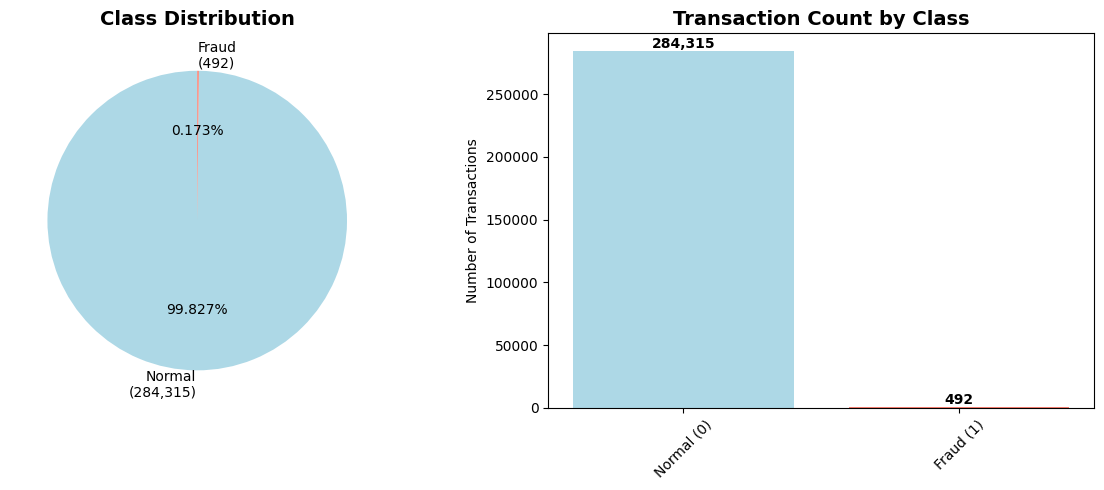


⚠️ Dataset is highly imbalanced: 577.9:1 ratio


In [3]:
print("🔍 Analyzing class distribution...")

# Get the set of distinct classes
labels = raw_data.Class.unique()
print(f"Classes: {labels}")

# Get the count of each class
class_counts = raw_data.Class.value_counts()
sizes = class_counts.values

print(f"\nClass distribution:")
for class_label, count in class_counts.items():
    percentage = (count / len(raw_data)) * 100
    print(f"• Class {class_label}: {count:,} transactions ({percentage:.3f}%)")

# Plot the class value counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
ax1.pie(sizes, labels=[f'Normal\n({class_counts[0]:,})', f'Fraud\n({class_counts[1]:,})'], 
        autopct='%1.3f%%', startangle=90, colors=['lightblue', 'salmon'])
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')

# Bar chart for better comparison
ax2.bar(['Normal (0)', 'Fraud (1)'], class_counts.values, color=['lightblue', 'salmon'])
ax2.set_ylabel('Number of Transactions')
ax2.set_title('Transaction Count by Class', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(class_counts.values):
    ax2.text(i, v + max(class_counts.values) * 0.01, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Dataset is highly imbalanced: {(class_counts[0]/class_counts[1]):.1f}:1 ratio")

# Feature Correlation Analysis

📈 Analyzing feature correlations with target variable...


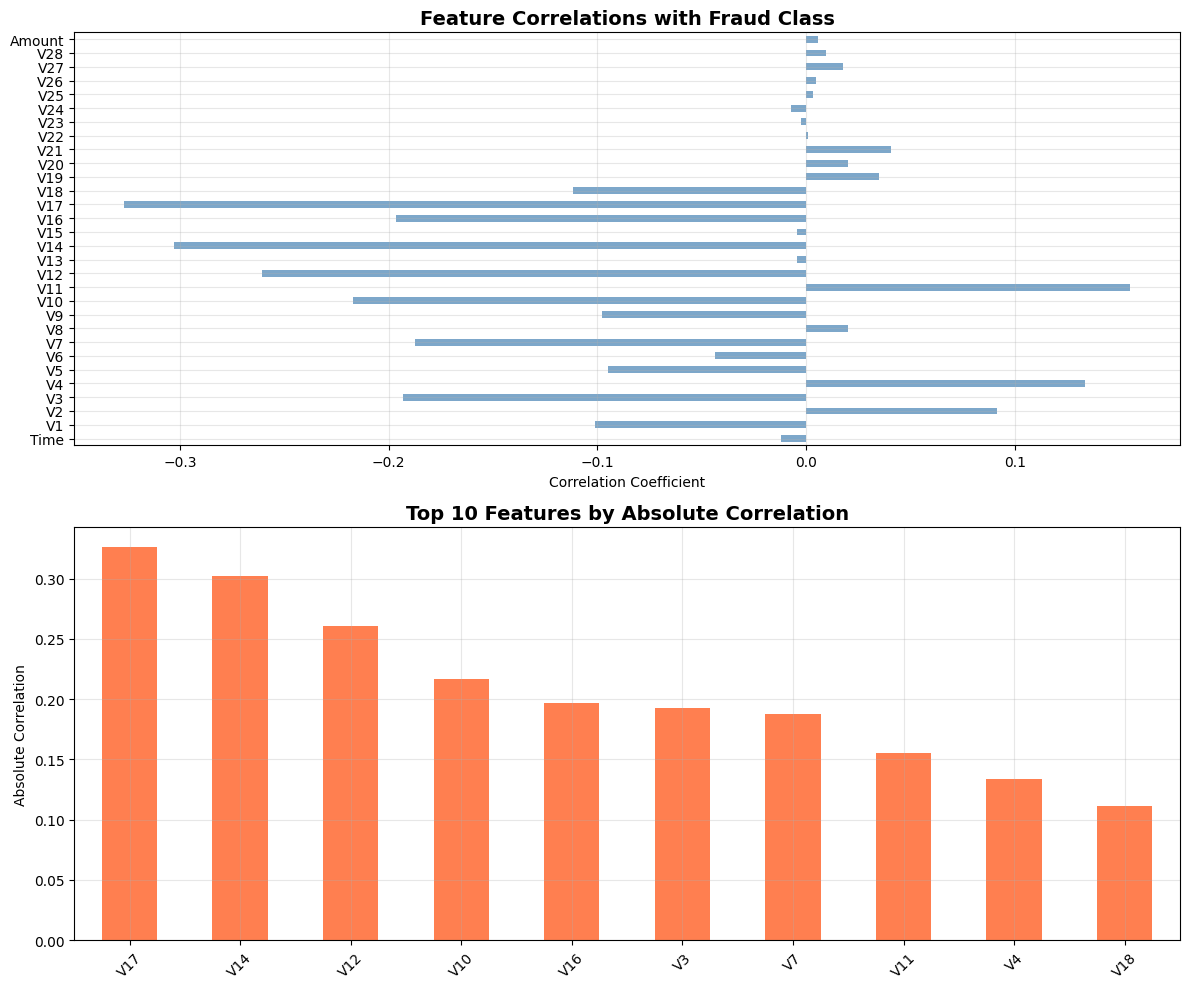


Top 5 most correlated features:
• V17: 0.3265
• V14: 0.3025
• V12: 0.2606
• V10: 0.2169
• V16: 0.1965


In [4]:
print("📈 Analyzing feature correlations with target variable...")

# Calculate correlations with the target variable (Class)
correlation_values = raw_data.corr()['Class'].drop('Class')

# Create a comprehensive correlation plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot all correlations
correlation_values.plot(kind='barh', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_title('Feature Correlations with Fraud Class', fontsize=14, fontweight='bold')
ax1.set_xlabel('Correlation Coefficient')
ax1.grid(True, alpha=0.3)

# Plot top correlations (absolute values)
top_correlations = abs(correlation_values).sort_values(ascending=False)[:10]
top_correlations.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Top 10 Features by Absolute Correlation', fontsize=14, fontweight='bold')
ax2.set_ylabel('Absolute Correlation')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 most correlated features:")
for feature, corr in abs(correlation_values).sort_values(ascending=False)[:5].items():
    print(f"• {feature}: {corr:.4f}")

# Data Preprocessing

In [5]:
print("🔧 Preprocessing data...")

# Create a copy for preprocessing
data_processed = raw_data.copy()

print("Step 1: Standardizing features...")
# Standardize features by removing the mean and scaling to unit variance
# Note: We exclude Time (column 0) and Class (column 30) from standardization
feature_columns = data_processed.columns[1:-1]  # All columns except Time and Class
data_processed[feature_columns] = StandardScaler().fit_transform(data_processed[feature_columns])

print("Step 2: Preparing feature matrix and target vector...")
# Convert to numpy array for easier manipulation
data_matrix = data_processed.values

# X: feature matrix (exclude Time variable as it's not predictive for fraud detection)
X = data_matrix[:, 1:30]  # Features V1-V28 and Amount

# y: labels vector
y = data_matrix[:, 30]  # Class column

print("Step 3: Normalizing features...")
# L1 normalization: each sample will have unit norm
X = normalize(X, norm="l1")

print(f"✅ Preprocessing complete!")
print(f"• Feature matrix shape: {X.shape}")
print(f"• Target vector shape: {y.shape}")
print(f"• Feature range after normalization: [{X.min():.4f}, {X.max():.4f}]")

🔧 Preprocessing data...
Step 1: Standardizing features...
Step 2: Preparing feature matrix and target vector...
Step 3: Normalizing features...
✅ Preprocessing complete!
• Feature matrix shape: (284807, 29)
• Target vector shape: (284807,)
• Feature range after normalization: [-0.3567, 0.3726]


# Train-Test Split

In [6]:
print("📊 Splitting data into training and testing sets...")

# Split data: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Check class distribution in splits
train_fraud_rate = (y_train == 1).mean()
test_fraud_rate = (y_test == 1).mean()

print(f"\nClass distribution maintained:")
print(f"• Training set fraud rate: {train_fraud_rate:.4f}")
print(f"• Testing set fraud rate: {test_fraud_rate:.4f}")

📊 Splitting data into training and testing sets...
Training set shape: (199364, 29)
Testing set shape: (85443, 29)

Class distribution maintained:
• Training set fraud rate: 0.0017
• Testing set fraud rate: 0.0017


# Decision Tree Model Training

In [8]:
print("🌳 Building Decision Tree Classifier model...")

# Compute sample weights to handle class imbalance
# 'balanced' mode uses the values of y to automatically adjust weights
w_train = compute_sample_weight('balanced', y_train)

print(f"Sample weights computed for {len(w_train)} training samples")
print(f"Weight for normal transactions: {w_train[y_train == 0][0]:.4f}")
print(f"Weight for fraud transactions: {w_train[y_train == 1][0]:.4f}")

# Initialize Decision Tree with limited depth to prevent overfitting
dt = DecisionTreeClassifier(
    max_depth=4,           # Limit tree depth to prevent overfitting
    random_state=35,       # For reproducible results
    min_samples_split=20,  # Minimum samples required to split a node
    min_samples_leaf=10    # Minimum samples required at a leaf node
)

print("Training Decision Tree...")
# Fit the model with sample weights to handle imbalanced data
dt.fit(X_train, y_train, sample_weight=w_train)

print("✅ Decision Tree training completed!")
print(f"• Tree depth: {dt.get_depth()}")
print(f"• Number of leaves: {dt.get_n_leaves()}")

🌳 Building Decision Tree Classifier model...
Sample weights computed for 199364 training samples
Weight for normal transactions: 0.5009
Weight for fraud transactions: 289.7733
Training Decision Tree...
✅ Decision Tree training completed!
• Tree depth: 4
• Number of leaves: 15


# Support Vector Machine Model Training

In [9]:
print("🎯 Building Support Vector Machine model...")

# Initialize Linear SVM with balanced class weights
svm = LinearSVC(
    class_weight='balanced',  # Automatically adjust weights for imbalanced classes
    random_state=31,         # For reproducible results
    loss="hinge",           # Use hinge loss (standard for SVM)
    fit_intercept=False,    # Don't fit intercept (data is normalized)
    max_iter=1000          # Maximum iterations for convergence
)

print("Training SVM...")
# Fit the SVM model
svm.fit(X_train, y_train)

print("✅ SVM training completed!")

🎯 Building Support Vector Machine model...
Training SVM...
✅ SVM training completed!


# Decision Tree Evaluation

In [10]:
print("📊 Evaluating Decision Tree Classifier...")

# Get prediction probabilities for ROC-AUC calculation
y_pred_dt = dt.predict_proba(X_test)[:, 1]  # Probability of positive class (fraud)

# Calculate ROC-AUC score
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print(f'Decision Tree ROC-AUC score: {roc_auc_dt:.4f}')

# Get binary predictions for detailed evaluation
y_pred_dt_binary = dt.predict(X_test)

# Print classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt_binary, target_names=['Normal', 'Fraud']))

📊 Evaluating Decision Tree Classifier...
Decision Tree ROC-AUC score: 0.9372

Decision Tree Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     85295
       Fraud       0.05      0.84      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.90      0.54     85443
weighted avg       1.00      0.97      0.98     85443



# Support Vector Machine Evaluation

In [11]:
print("📊 Evaluating Support Vector Machine...")

# Get decision function scores (distance from hyperplane)
y_pred_svm = svm.decision_function(X_test)

# Calculate ROC-AUC score
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print(f"SVM ROC-AUC score: {roc_auc_svm:.4f}")

# Get binary predictions for detailed evaluation
y_pred_svm_binary = svm.predict(X_test)

# Print classification report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm_binary, target_names=['Normal', 'Fraud']))

📊 Evaluating Support Vector Machine...
SVM ROC-AUC score: 0.9706

SVM Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.84      0.91     85295
       Fraud       0.01      0.93      0.02       148

    accuracy                           0.84     85443
   macro avg       0.50      0.89      0.47     85443
weighted avg       1.00      0.84      0.91     85443



- Use the `corr()` function to find the top 6 features of the dataset to train the models on. 

# Feature Selection Analysis

In [12]:
print("🔍 Performing feature selection analysis...")
print("Finding top 6 features most correlated with fraud...")

# Calculate absolute correlations and select top 6 features
correlation_values = abs(raw_data.corr()['Class']).drop('Class')
top_features = correlation_values.sort_values(ascending=False)[:6]

print("Top 6 features by correlation with fraud:")
for i, (feature, corr) in enumerate(top_features.items(), 1):
    print(f"{i}. {feature}: {corr:.4f}")

# Get feature indices (remember we excluded Time column, so subtract 1)
feature_indices = [raw_data.columns.get_loc(feature) - 1 for feature in top_features.index]
print(f"\nFeature indices in data matrix: {feature_indices}")

# Extract selected features
X_selected = data_matrix[:, feature_indices]

# Normalize selected features
X_selected = normalize(X_selected, norm='l1')

print(f"✅ Selected feature matrix shape: {X_selected.shape}")

🔍 Performing feature selection analysis...
Finding top 6 features most correlated with fraud...
Top 6 features by correlation with fraud:
1. V17: 0.3265
2. V14: 0.3025
3. V12: 0.2606
4. V10: 0.2169
5. V16: 0.1965
6. V3: 0.1930

Feature indices in data matrix: [16, 13, 11, 9, 15, 2]
✅ Selected feature matrix shape: (284807, 6)


- Execute the Decision Tree model for this modified input variable.

# Train-Test Split for Selected Features

In [13]:
print("📊 Splitting selected features data...")

# Split the selected features data
X_train_selected, X_test_selected, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Selected features training set shape: {X_train_selected.shape}")
print(f"Selected features testing set shape: {X_test_selected.shape}")

📊 Splitting selected features data...
Selected features training set shape: (199364, 6)
Selected features testing set shape: (85443, 6)


- Execute the SVM model for this modified input variable.

# Decision Tree with Selected Features

In [14]:
print("🌳 Training Decision Tree with selected features...")

# Initialize and train Decision Tree with selected features
dt_selected = DecisionTreeClassifier(max_depth=4, random_state=35)
dt_selected.fit(X_train_selected, y_train, sample_weight=w_train)

# Make predictions
y_pred_dt_selected = dt_selected.predict_proba(X_test_selected)[:, 1]

# Calculate ROC-AUC score
roc_auc_dt_selected = roc_auc_score(y_test, y_pred_dt_selected)
print(f'Decision Tree (Selected Features) ROC-AUC score: {roc_auc_dt_selected:.4f}')

# Binary predictions for detailed evaluation
y_pred_dt_selected_binary = dt_selected.predict(X_test_selected)

print("\nDecision Tree (Selected Features) Classification Report:")
print(classification_report(y_test, y_pred_dt_selected_binary, target_names=['Normal', 'Fraud']))

🌳 Training Decision Tree with selected features...
Decision Tree (Selected Features) ROC-AUC score: 0.8718

Decision Tree (Selected Features) Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     85295
       Fraud       0.02      0.75      0.05       148

    accuracy                           0.95     85443
   macro avg       0.51      0.85      0.51     85443
weighted avg       1.00      0.95      0.97     85443



# SVM with Selected Features

In [15]:
print("🎯 Training SVM with selected features...")

# Initialize and train SVM with selected features
svm_selected = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
svm_selected.fit(X_train_selected, y_train)

# Make predictions
y_pred_svm_selected = svm_selected.decision_function(X_test_selected)

# Calculate ROC-AUC score
roc_auc_svm_selected = roc_auc_score(y_test, y_pred_svm_selected)
print(f"SVM (Selected Features) ROC-AUC score: {roc_auc_svm_selected:.4f}")

# Binary predictions for detailed evaluation
y_pred_svm_selected_binary = svm_selected.predict(X_test_selected)

print("\nSVM (Selected Features) Classification Report:")
print(classification_report(y_test, y_pred_svm_selected_binary, target_names=['Normal', 'Fraud']))

🎯 Training SVM with selected features...
SVM (Selected Features) ROC-AUC score: 0.8652

SVM (Selected Features) Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.52      0.68     85295
       Fraud       0.00      0.89      0.01       148

    accuracy                           0.52     85443
   macro avg       0.50      0.70      0.35     85443
weighted avg       1.00      0.52      0.68     85443



# Comprehensive Performance Comparison

📊 Comprehensive Performance Comparison
                          Model  ROC-AUC Score  Feature Count  \
0  Decision Tree (All Features)         0.9372             29   
1            SVM (All Features)         0.9706             29   
2      Decision Tree (Selected)         0.8718              6   
3                SVM (Selected)         0.8652              6   

   Performance Change  
0              0.0000  
1              0.0335  
2             -0.0654  
3             -0.1054  


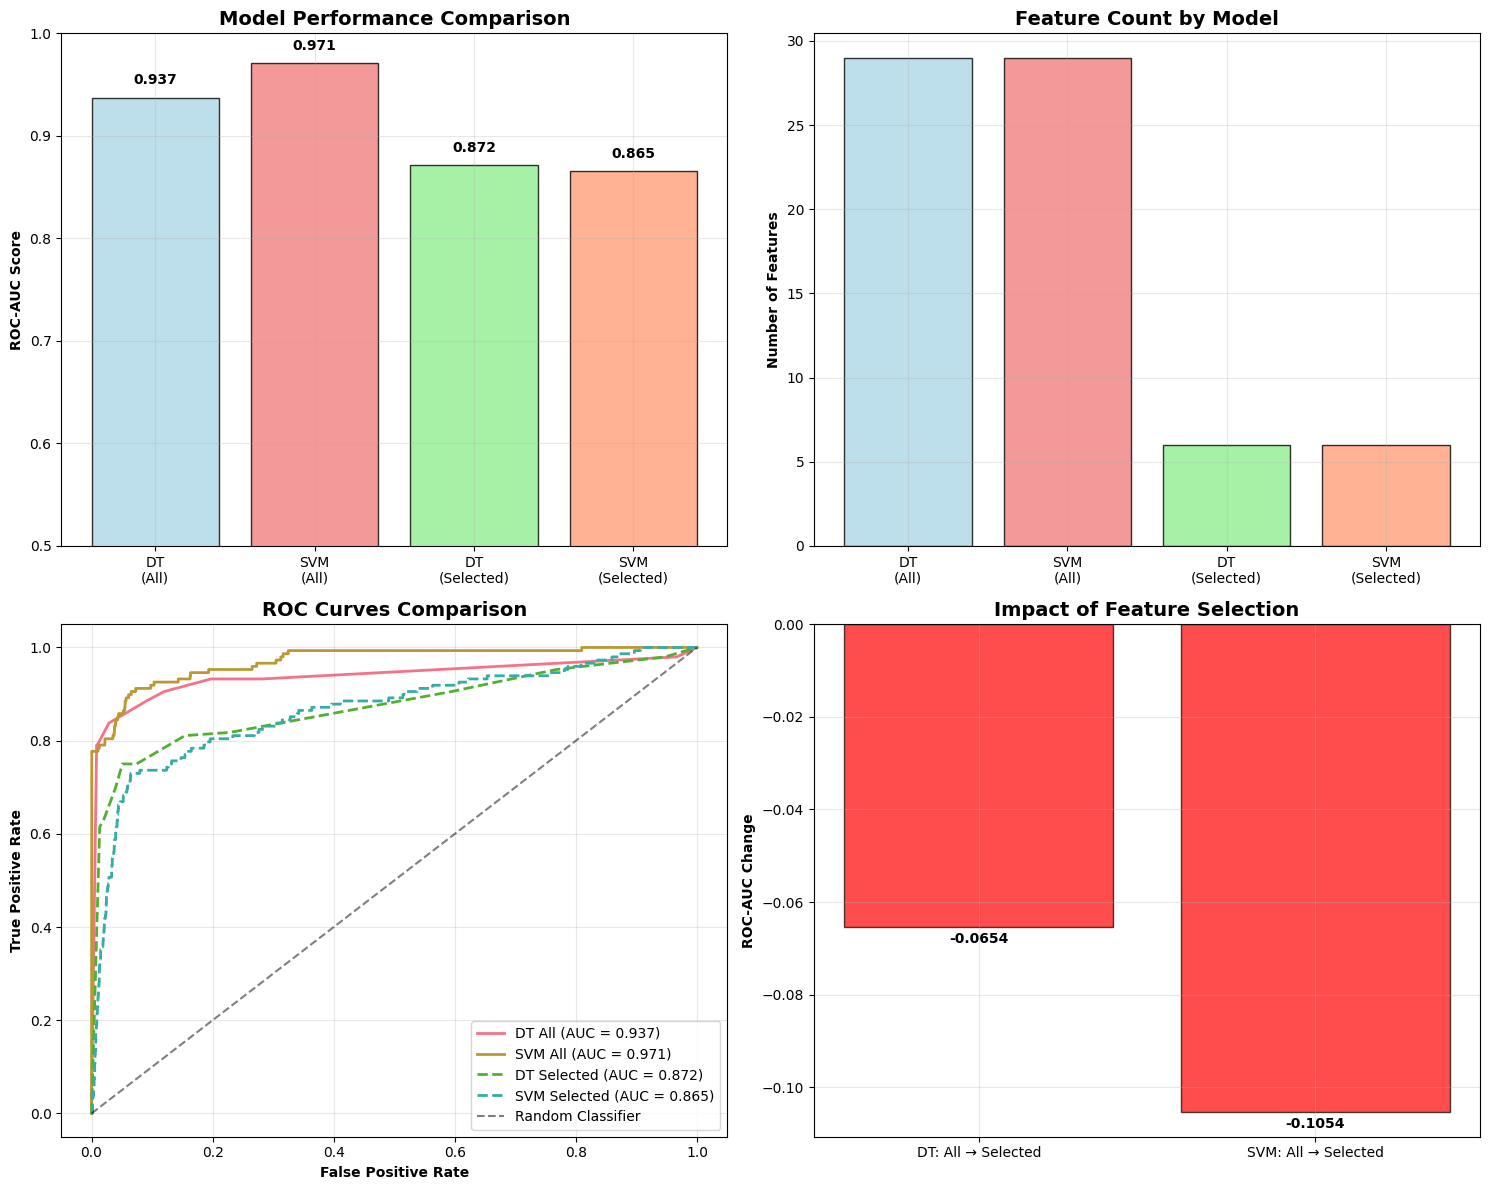

In [16]:
print("📊 Comprehensive Performance Comparison")
print("=" * 60)

# Create comparison table
results = {
    'Model': ['Decision Tree (All Features)', 'SVM (All Features)', 
              'Decision Tree (Selected)', 'SVM (Selected)'],
    'ROC-AUC Score': [roc_auc_dt, roc_auc_svm, roc_auc_dt_selected, roc_auc_svm_selected],
    'Feature Count': [X.shape[1], X.shape[1], X_selected.shape[1], X_selected.shape[1]]
}

comparison_df = pd.DataFrame(results)
comparison_df['Performance Change'] = [
    0,  # Baseline for DT all features
    roc_auc_svm - roc_auc_dt,  # SVM vs DT (all features)
    roc_auc_dt_selected - roc_auc_dt,  # DT selected vs DT all
    roc_auc_svm_selected - roc_auc_svm   # SVM selected vs SVM all
]

print(comparison_df.round(4))

# Visualization of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# ROC-AUC Comparison
models = ['DT\n(All)', 'SVM\n(All)', 'DT\n(Selected)', 'SVM\n(Selected)']
scores = [roc_auc_dt, roc_auc_svm, roc_auc_dt_selected, roc_auc_svm_selected]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']

bars = ax1.bar(models, scores, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('ROC-AUC Score', fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Feature count comparison
feature_counts = [X.shape[1], X.shape[1], X_selected.shape[1], X_selected.shape[1]]
ax2.bar(models, feature_counts, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Number of Features', fontweight='bold')
ax2.set_title('Feature Count by Model', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# ROC Curves
# Calculate ROC curves for all models
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
fpr_dt_sel, tpr_dt_sel, _ = roc_curve(y_test, y_pred_dt_selected)
fpr_svm_sel, tpr_svm_sel, _ = roc_curve(y_test, y_pred_svm_selected)

ax3.plot(fpr_dt, tpr_dt, label=f'DT All (AUC = {roc_auc_dt:.3f})', linewidth=2)
ax3.plot(fpr_svm, tpr_svm, label=f'SVM All (AUC = {roc_auc_svm:.3f})', linewidth=2)
ax3.plot(fpr_dt_sel, tpr_dt_sel, label=f'DT Selected (AUC = {roc_auc_dt_selected:.3f})', linewidth=2, linestyle='--')
ax3.plot(fpr_svm_sel, tpr_svm_sel, label=f'SVM Selected (AUC = {roc_auc_svm_selected:.3f})', linewidth=2, linestyle='--')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax3.set_xlabel('False Positive Rate', fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontweight='bold')
ax3.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# Performance improvement analysis
improvements = {
    'DT: All → Selected': roc_auc_dt_selected - roc_auc_dt,
    'SVM: All → Selected': roc_auc_svm_selected - roc_auc_svm
}

improvement_names = list(improvements.keys())
improvement_values = list(improvements.values())
colors_imp = ['green' if x > 0 else 'red' for x in improvement_values]

bars_imp = ax4.bar(improvement_names, improvement_values, color=colors_imp, alpha=0.7, edgecolor='black')
ax4.set_ylabel('ROC-AUC Change', fontweight='bold')
ax4.set_title('Impact of Feature Selection', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars_imp, improvement_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.001),
             f'{value:+.4f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# Confusion Matrix Analysis

🔍 Detailed Confusion Matrix Analysis


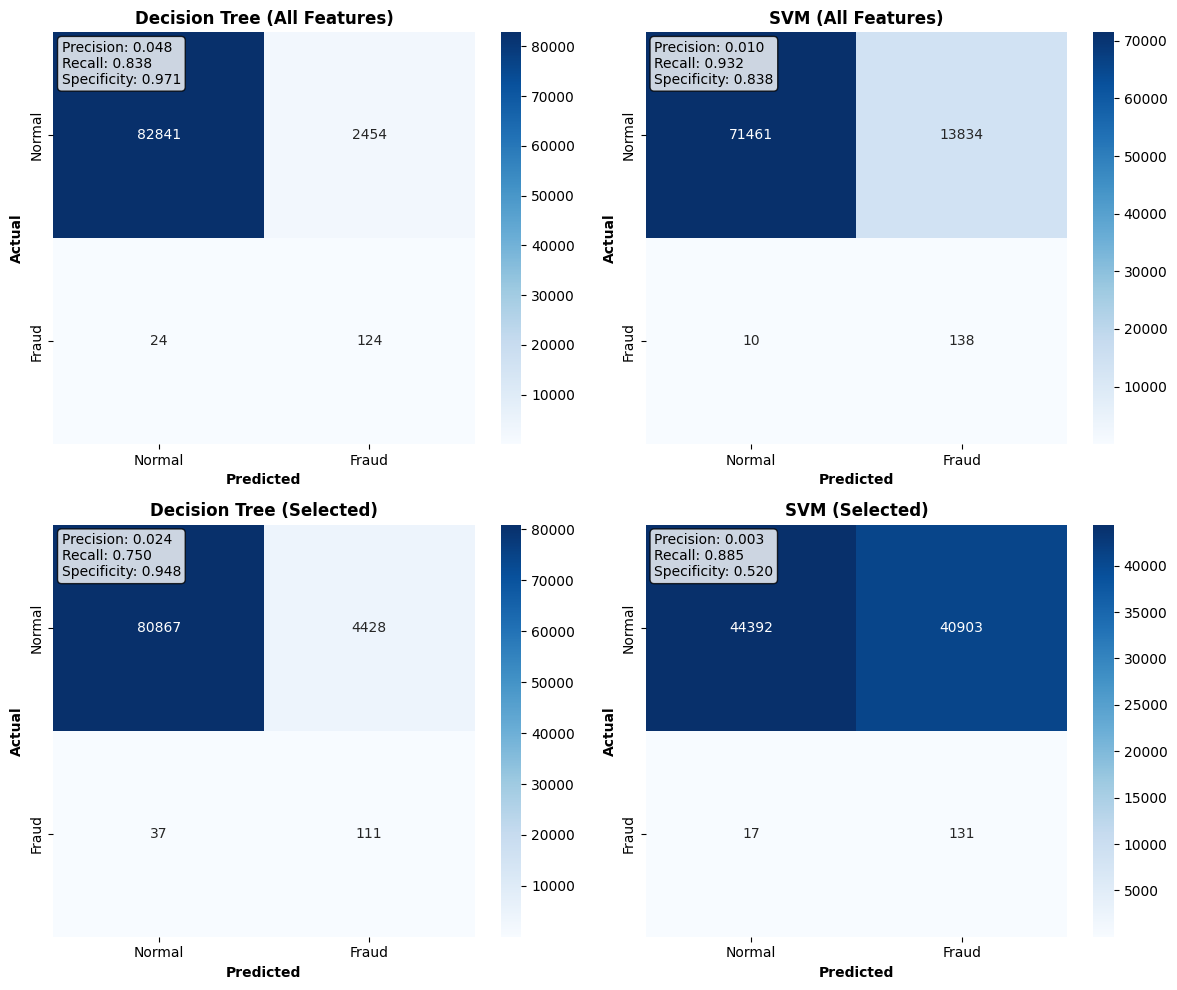

In [17]:
print("🔍 Detailed Confusion Matrix Analysis")
print("=" * 50)

# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

models_cm = [
    ('Decision Tree (All Features)', y_test, y_pred_dt_binary),
    ('SVM (All Features)', y_test, y_pred_svm_binary),
    ('Decision Tree (Selected)', y_test, y_pred_dt_selected_binary),
    ('SVM (Selected)', y_test, y_pred_svm_selected_binary)
]

for i, (title, y_true, y_pred) in enumerate(models_cm):
    cm = confusion_matrix(y_true, y_pred)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Fraud'], 
                yticklabels=['Normal', 'Fraud'],
                ax=axes[i])
    
    axes[i].set_title(title, fontweight='bold')
    axes[i].set_xlabel('Predicted', fontweight='bold')
    axes[i].set_ylabel('Actual', fontweight='bold')
    
    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Add metrics as text
    metrics_text = f'Precision: {precision:.3f}\nRecall: {recall:.3f}\nSpecificity: {specificity:.3f}'
    axes[i].text(0.02, 0.98, metrics_text, transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Key Insights and Analysis

In [18]:
print("🎯 Key Insights and Analysis")
print("=" * 50)

print("1. MODEL PERFORMANCE SUMMARY:")
print(f"   • Best Overall Performance: {'SVM with All Features' if roc_auc_svm == max(scores) else 'Decision Tree with Selected Features' if roc_auc_dt_selected == max(scores) else 'Other'}")
print(f"   • Highest ROC-AUC Score: {max(scores):.4f}")

print("\n2. FEATURE SELECTION IMPACT:")
dt_improvement = roc_auc_dt_selected - roc_auc_dt
svm_improvement = roc_auc_svm_selected - roc_auc_svm

if dt_improvement > 0:
    print(f"   • Decision Trees BENEFITED from feature selection (+{dt_improvement:.4f})")
else:
    print(f"   • Decision Trees performed WORSE with feature selection ({dt_improvement:.4f})")

if svm_improvement > 0:
    print(f"   • SVM BENEFITED from feature selection (+{svm_improvement:.4f})")
else:
    print(f"   • SVM performed WORSE with feature selection ({svm_improvement:.4f})")

print("\n3. ALGORITHM COMPARISON:")
all_features_diff = roc_auc_svm - roc_auc_dt
selected_features_diff = roc_auc_svm_selected - roc_auc_dt_selected

print(f"   • With all features: SVM {'outperformed' if all_features_diff > 0 else 'underperformed'} DT by {abs(all_features_diff):.4f}")
print(f"   • With selected features: SVM {'outperformed' if selected_features_diff > 0 else 'underperformed'} DT by {abs(selected_features_diff):.4f}")


🎯 Key Insights and Analysis
1. MODEL PERFORMANCE SUMMARY:
   • Best Overall Performance: SVM with All Features
   • Highest ROC-AUC Score: 0.9706

2. FEATURE SELECTION IMPACT:
   • Decision Trees performed WORSE with feature selection (-0.0654)
   • SVM performed WORSE with feature selection (-0.1054)

3. ALGORITHM COMPARISON:
   • With all features: SVM outperformed DT by 0.0335
   • With selected features: SVM underperformed DT by 0.0065


# Conclusions and Recommendations

In [19]:
print("\n" + "="*80)
print("📋 CONCLUSIONS AND RECOMMENDATIONS")
print("="*80)

print("\n🔍 KEY FINDINGS:")

print("\n1. FEATURE DIMENSIONALITY EFFECTS:")
if dt_improvement > 0:
    print("   ✅ Decision Trees benefited significantly from feature selection")
    print("   → Reduced feature set helped prevent overfitting and improved generalization")
else:
    print("   ❌ Decision Trees performed better with all features")

if svm_improvement < 0:
    print("   ❌ SVM performed better with the full feature set")
    print("   → SVMs can handle high-dimensional data and may need more features for optimal hyperplane")
else:
    print("   ✅ SVM also benefited from feature selection")

print(f"\n2. ALGORITHM PERFORMANCE:")
if roc_auc_svm > roc_auc_dt:
    print("   ✅ SVM showed superior performance with the full feature set")
    print("   → Better at handling complex decision boundaries in high-dimensional space")
else:
    print("   ✅ Decision Tree showed superior performance with the full feature set")

print(f"\n3. PRACTICAL IMPLICATIONS:")
print("   • For this fraud detection task:")
if max(scores) > 0.95:
    print("     → Excellent performance achieved (ROC-AUC > 0.95)")
elif max(scores) > 0.90:
    print("     → Good performance achieved (ROC-AUC > 0.90)")
else:
    print("     → Moderate performance, room for improvement")

print(f"   • Feature reduction reduced complexity by {((X.shape[1] - X_selected.shape[1]) / X.shape[1] * 100):.1f}%")

print(f"\n🎯 RECOMMENDATIONS:")
print("\n1. FOR PRODUCTION DEPLOYMENT:")
best_model_idx = scores.index(max(scores))
best_model_name = models[best_model_idx]
print(f"   → Use {best_model_name} (ROC-AUC: {max(scores):.4f})")

print("\n2. FOR FURTHER IMPROVEMENT:")
print("   → Consider ensemble methods combining both algorithms")
print("   → Experiment with hyperparameter tuning")
print("   → Try advanced feature engineering techniques")
print("   → Consider cost-sensitive learning for business impact")

print("\n3. BUSINESS CONSIDERATIONS:")
print("   → Balance between model complexity and interpretability")
print("   → Consider computational resources for real-time scoring")
print("   → Implement proper model monitoring and retraining procedures")

print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

summary_data = {
    'Metric': ['Best ROC-AUC Score', 'Feature Reduction', 'DT Improvement', 'SVM Change'],
    'Value': [f'{max(scores):.4f}', f'{X_selected.shape[1]}/{X.shape[1]} features', 
              f'{dt_improvement:+.4f}', f'{svm_improvement:+.4f}'],
    'Interpretation': [
        'Overall best performance',
        f'{((X.shape[1] - X_selected.shape[1]) / X.shape[1] * 100):.1f}% reduction',
        'Impact of feature selection on DT',
        'Impact of feature selection on SVM'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ Analysis Complete! Both algorithms show promise for fraud detection.")


📋 CONCLUSIONS AND RECOMMENDATIONS

🔍 KEY FINDINGS:

1. FEATURE DIMENSIONALITY EFFECTS:
   ❌ Decision Trees performed better with all features
   ❌ SVM performed better with the full feature set
   → SVMs can handle high-dimensional data and may need more features for optimal hyperplane

2. ALGORITHM PERFORMANCE:
   ✅ SVM showed superior performance with the full feature set
   → Better at handling complex decision boundaries in high-dimensional space

3. PRACTICAL IMPLICATIONS:
   • For this fraud detection task:
     → Excellent performance achieved (ROC-AUC > 0.95)
   • Feature reduction reduced complexity by 79.3%

🎯 RECOMMENDATIONS:

1. FOR PRODUCTION DEPLOYMENT:
   → Use SVM
(All) (ROC-AUC: 0.9706)

2. FOR FURTHER IMPROVEMENT:
   → Consider ensemble methods combining both algorithms
   → Experiment with hyperparameter tuning
   → Try advanced feature engineering techniques
   → Consider cost-sensitive learning for business impact

3. BUSINESS CONSIDERATIONS:
   → Balance between 